In [ ]:
!pip install -qU langgraph langsmith langchain_anthropic langchain langchain-community

# Introduction

## Setup

In [ ]:
import os

os.environ["ANTHROPIC_API_KEY"] = "YOUR_ANTHROPIC_API_KEY"

# Build a Basic Chatbot

Start with a `StateGraph`, which defines the structure of the chatbot as a "state machine". We later will add
* `nodes` to represent the LLM and functions which the chatbot can call, and
* `edges` to specify how the bot should transition between these functions.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [ ]:
class State(TypedDict):
    # Messages have the type "list".
    # The `add_messages` function in the annotation
    # defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
graph_builder

The first thing when defining a graph is define the `State` of the graph. The `State` consists of the schema of the graph and `reducer functions` which specify how to apply updates to the state.

Here, `State` is a `TypedDict` with a single key: `messages`. The `messages` key is annotated with the `add_messages` reducer function, which tells LangGraph to append new messages to the existing list, rather than overwriting it.

`State` keys without an annotation will be overwritten by each update, storing the most recent value.

The graph we defined knows two things:
1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be appended to the current list, rather than directly overwritten. This is communicated via the prebuilt `add_messages` function in the `Annotated` syntax.

Next, we add a "`chatbot`" node. Nodes represent units of work. They are typically regular python functions.

In [ ]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

def chatbot(state: State):
    return {
        'messages': [llm.invoke(state['messages'])]
    }

In [ ]:
# 1st arg is the unique node name
# 2nd arg is the function or object called when the node is used
graph_builder.add_node('chatbot', chatbot)

The `chatbot` node function takes the current `State` as input and returns a dictionary containing an updated `messages` list under the key `"messages"`. This is the basic pattern for all LangGraph node functions.

The `add_messages` function in the `State` will append the LLM's response messages to whatever messages are already in the state.

Next, we add an `entry` point, which tells our graph **where to start its work**:

In [ ]:
graph_builder.add_edge(START, 'chatbot')

Similarly, we need to set a `finish` point, which instructs the graph **any time this node is run, we can exit**.

In [ ]:
graph_builder.add_edge('chatbot', END)

Finally, to run the graph, we cal `compile()` on the `graph_builder`, which creates a `CompiledGraph` we can use invoke on our state:

In [ ]:
graph = graph_builder.compile()

We can visualize the graph as following:

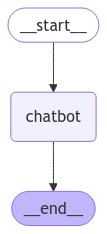

In [ ]:
from IPython.display import Image, display

display(Image(
    graph.get_graph().draw_mermaid_png()
))

Now we can test this chatbot. We can exit the chatbot loop at any time by typing "quit", "exit" or "q".

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({'messages': [('user', user_input)]}):
        for value in event.values():
            print("Assistant:", value['messages'][-1].content)

In [ ]:
exit_msg = ['quit', 'exit', 'q']
while True:
    try:
        user_input = input('User: ')
        if user_input.lower() in exit_msg:
            print('Goodbye!')
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)

        stream_graph_updates(user_input)
        break

User: Hi
Assistant: Hello! How can I assist you today? Feel free to ask any questions or let me know if you need help with anything.
User: What is your name?
Assistant: My name is Claude.
User: what version are you?
Assistant: I'm Claude, an AI assistant created by Anthropic to be helpful, harmless, and honest. I don't have a specific version number.
User: are you 3.5 or 2.5?
Assistant: I am Claude, an AI assistant created by Anthropic to be helpful, harmless, and honest. I don't have a version number like 3.5 or 2.5.
User: which is larger, 9.11 or 9.8?
Assistant: To compare decimal numbers, we can look at each digit from left to right.

1) First, let's compare the whole number part:
   Both numbers have 9 as the whole number, so we need to look at the decimal part.

2) Now, let's compare the tenths (the first digit after the decimal point):
   9.11 has 1 in the tenths place
   9.8 has 8 in the tenths place

3) Since 8 is greater than 1, we don't need to look any further.

Therefore, 9

# Enhancing the Chatbot with Tools

We can integrate a web search tool to find relevant information and provide better responses.

In [ ]:
import os

os.environ['TAVILY_API_KEY'] = 'YOUR_TAVILY_API_KEY'

Define the search tool:

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

search_tool = TavilySearchResults(max_reuslts=3)
tools = [search_tool]

In [ ]:
# test the tool
search_results = search_tool.invoke("What is a node in LangGraph?")
search_results

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'},
 {'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': 'StateGraph: StateGraph in LangGraph is a class that allows us to create graphs whose nodes communicate by reading and writing to a shared state. The StateGraph class is parameterized by a user'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. On

In [ ]:
search_results[0].keys()

dict_keys(['url', 'content'])

The results contain page summaries that our chatbot can use to answer questions.

Next, we can start defining our graph.

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model='claude-3-5-sonnet-20240620')
# Add tools
llm_with_tools = llm.bind_tools(tools)


def chatbot_with_tools(state: State):
    return {
        'messages': [llm_with_tools.invoke(state['messages'])]
    }

graph_builder.add_node('chatbot-tools', chatbot_with_tools)

Next we need to create a function to actually run the tools if they are called. We need to implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`. It relies on the LLM's `tool_calling` support.

In [ ]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage"""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get('messages', []):
            message = messages[-1]
        else:
            raise ValueError('No message found in input')

        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call['name']].invoke(tool_call['args'])
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call['name'],
                    tool_call_id=tool_call['id'],
                )
            )


        return {'messages': outputs}


# create a tool node
tool_node = BasicToolNode(tools=[search_tool])
# add this node to graph
graph_builder.add_node('tools', tool_node)

With the tool node added, we can define the `conditional_edges`.

The **edges** route the control flow from one node to the next. **Conditional edges** usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph `state` and return a string or a list of strings indicating which node(s) to call next.

We will define a router function called `route_tools` that checks for tool calls in the chatbot's output. Then we pass it to the graph by calling `add_conditional_edges`, which tells the graph that whenver the `chatbot` node completes to check this function to see where to go next. The condition will route to `tools` if tool calls are present and `END` if not.

In [ ]:
from typing import Literal


def route_tools(state: State):
    """
    Used in the conditional-edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the END.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get('messages', []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
        return 'tools'
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool,
# and "END" if it is fine directly responding.
# This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    'chatbot-tools',
    route_tools,
    # The following dictionary lets us tell the graph to interpret the condition's outputs
    # as a specific node.
    # It defaults to the identity function, but if us want to use a node
    # named something else apart from "tools",
    # we can update the value of the dictionary to something else,
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END}
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge('tools', 'chatbot-tools')
graph_builder.add_edge(START, 'chatbot-tools')

graph = graph_builder.compile()

The conditional edges start from a single node, which tells the graph "any time the `chatbot` node runs, either go to `tools` if it calls a tool, or end the loop if it responds directly.

When the graph transitions to `END`, it has no more tasks to complete and ceases execution. Because the condition can return `END`, we do not need to explicitly set a `finish_point` this time.

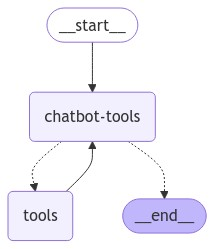

In [ ]:
from IPython.display import Image, display

display(Image(
    graph.get_graph().draw_mermaid_png()
))

Now we can ask the chatbot questions outside its trianing data:

In [ ]:
exit_msg = ['quit', 'exit', 'q']
while True:
    try:
        user_input = input('User: ')
        if user_input.lower() in exit_msg:
            print('Goodbye!')
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)

        stream_graph_updates(user_input)
        break

User: Hi
Assistant: Hello! Welcome. How can I assist you today? I'm here to help with any questions or tasks you might have. Is there anything specific you'd like to know or discuss?
User: What do you know about LangChain?
Assistant: [{'text': "To provide you with accurate and up-to-date information about LangChain, I'll need to search for the latest details. Let me do that for you.", 'type': 'text'}, {'id': 'toolu_014gzkFn5FoDanJ8ApnnR8JJ', 'input': {'query': 'LangChain framework for AI applications'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"url": "https://www.33rdsquare.com/langchain/", "content": "Core Concepts\nA LangChain application consists of 5 key components working in conjunction:\nLLM Wrappers\u2026\nPrompts\nChains\nVector Stores\nAgents\nEvolution of LangChain\nLangChain originated from techniques detailed in academic papers published by researchers at Anthropic \u2013 an AI safety startup that open sourced the framework [2].\n This compreh

Our chatbot still can't remember past interaction on its own, limiting its ability to have coherent, multi-turn converations.

We can now replace our `BasicToolNode` for the prebuilt `ToolNode` and our `route_tools` condition with the prebuilt `tools_condition`:

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition



class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model='claude-3-5-sonnet-20240620')
# Add tools
llm_with_tools = llm.bind_tools(tools)


def chatbot_with_tools(state: State):
    return {
        'messages': [llm_with_tools.invoke(state['messages'])]
    }

graph_builder.add_node('chatbot-tools', chatbot_with_tools)

# Define tool node
tool_node = ToolNode(tools=tools)
graph_builder.add_node('tools', tool_node)

# Add conditional edge
graph_builder.add_conditional_edges(
    "chatbot-tools",
    tools_condition,
)


# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge('tools', 'chatbot-tools')
graph_builder.set_entry_point('chatbot-tools')

graph = graph_builder.compile()

# Add Memory to the Chatbot

LangGraph can enable multi-turn interactions by enabling **persistent checkpointing**. If we provide a `checkpointer` when compiling the graph and a `thread_id` when calling our graph, LangGraph automatically saves the state after each step. When we invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

We are using an in-memory checkpointer. In a production application, we may want to change this to use `SqliteSaver` or `PostgresSaver` and connect to our own database.

Next, define the graph with tools.

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# add tools
tool = TavilySearchResults(max_results=2)
tools = [tool]
# add llm
llm = ChatAnthropic(model='claude-3-5-sonnet-20240620')
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {
        'messages': [llm_with_tools.invoke(state['messages'])]
    }

graph_builder.add_node('chatbot', chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node('tools', tool_node)

graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition,
)

graph_builder.add_edge('tools', 'chatbot')
graph_builder.add_edge(START, 'chatbot')

# Compile the graph with the checkpointer
graph = graph_builder.compile(checkpointer=memory)

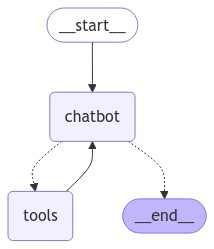

In [ ]:
from IPython.display import Image, display

display(Image(
    graph.get_graph().draw_mermaid_png()
))

The connectivity of the graph has not changed but we add a memory checkpointer.

Now we can interact with our bot. First, create a thread id to use:

In [ ]:
config = {
    'configurable': {'thread_id': '1'}
}

# then we can call the bot
user_input = 'Hi! My name is Bin'

# config is passed as the positional argument
events = graph.stream(
    {'messages': [('user', user_input)]},
    config,
    stream_mode='values',
)

for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi! My name is Bin
================================== Ai Message ==================================

Hello Bin! It's nice to meet you. How can I assist you today? Is there any specific information you're looking for or any questions you have?


The `config` was provided as the **2nd positional argument** when calling our graph.

We can check if our bot remember our name:

In [ ]:
user_input = 'What is my name?'

events = graph.stream(
    {'messages': [('user', user_input)]},
    config,
    stream_mode='values',
)

for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Bin. You introduced yourself at the beginning of our conversation.


If we set up with another thread id:

In [ ]:
events = graph.stream(
    {'messages': [('user', user_input)]},
    {'configurable': {'thread_id': '2'}},
    stream_mode='values',
)

for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I apologize, but I don't have access to personal information about individual users. As an AI language model, I don't have knowledge of specific individuals or their personal details. Is there something else I can help you with or a different question you'd like to ask?


We can inspect a graph's `state` for a given `config` at any time:

In [ ]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi! My name is Bin', additional_kwargs={}, response_metadata={}, id='33d2a085-bb3f-490c-bf1c-8686bf973b8a'), AIMessage(content="Hello Bin! It's nice to meet you. How can I assist you today? Is there any specific information you're looking for or any questions you have?", additional_kwargs={}, response_metadata={'id': 'msg_01SC1aLkWtRw3HZXisWZeYcX', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 404, 'output_tokens': 36}}, id='run-30a4ab20-602a-4d26-a188-f2b6d0f20800-0', usage_metadata={'input_tokens': 404, 'output_tokens': 36, 'total_tokens': 440, 'input_token_details': {}}), HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='71421686-77fc-45c1-b4c6-2833f24a7b4c'), AIMessage(content='Your name is Bin. You introduced yourself at the beginning of our conversation.', additional_kwargs={}, response_metadata={'id': 'msg_01PARjcBff

In [ ]:
snapshot.next

()

The `snapshot` contains the current state values, corresponding config, and the `next` node to process. In our case, the graph has reached an `END` state, so `next` is empty.

# Human-in-the-loop

LangGraph supports `human-in-the-loop` workflows in a number of ways. In this section, we use `interrupt_before` functionality to always break the tool node.

Reuse the our graph from last section:

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Now we can compile the graph, specifying to `interrupt_before` the `tools` node.

In [ ]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=['tools'], # newly added here
    # there is also an `interrupt_after`
    # interrupt_after=['tools'],
)

In [ ]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {'configurable': {'thread_id': '1'}}

# add config to stream or invoke method
events = graph.stream(
    {'messages': [('user', user_input)]},
    config,
    stream_mode='values',
)

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to research LangGraph for you. To get the most up-to-date and comprehensive information, I'll use the Tavily search engine. Let me search for information about LangGraph.", 'type': 'text'}, {'id': 'toolu_01XC8Nm2oKin3nWf4b5VTib5', 'input': {'query': 'LangGraph: what is it, how is it used in AI development'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01XC8Nm2oKin3nWf4b5VTib5)
 Call ID: toolu_01XC8Nm2oKin3nWf4b5VTib5
  Args:
    query: LangGraph: what is it, how is it used in AI development


We can inspect the graph state to confirm if it worked:

In [ ]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

Unlike last time, the "next" node is set to `'tools'`. We have interrupted here. Now we can check the tool invocation:

In [ ]:
existing_message = snapshot.values['messages'][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph: what is it, how is it used in AI development'},
  'id': 'toolu_01XC8Nm2oKin3nWf4b5VTib5',
  'type': 'tool_call'}]

This query seems reasonable. The simplest thing the human can do is to allow the graph continue executing.

To continue the graph, we need to pass in `None` so the graph can continue where it left off without adding anything new to the state.

In [ ]:
# `None` will append nothing new to the current state,
# letting it resume as if it had never been interrupted.
events = graph.stream(
    None,
    config,
    stream_mode='values',
)

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to research LangGraph for you. To get the most up-to-date and comprehensive information, I'll use the Tavily search engine. Let me search for information about LangGraph.", 'type': 'text'}, {'id': 'toolu_01XC8Nm2oKin3nWf4b5VTib5', 'input': {'query': 'LangGraph: what is it, how is it used in AI development'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01XC8Nm2oKin3nWf4b5VTib5)
 Call ID: toolu_01XC8Nm2oKin3nWf4b5VTib5
  Args:
    query: LangGraph: what is it, how is it used in AI development
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem designed to tackle these challenges head-on. LangGraph provides a framework fo

Notice that the state is loaded in the first step so that our chatbot can continue where it left off.

This is how we can use an `interrupt` method to add human-in-the-loop execution to our chatbot, allowing for human oversight and intervention when needed.

# Manually Updating the State

In the previous section, we interrupted a graph so that a human could inspect its actions. This lets the human `read` the state, but if they want to change their agent's course, they will need to have `write` access.

Updating the state lets us control the agent's trajectory by modifying its actions. This is useful when we want to correct the agent's mistakes, explore alternative paths, or guide the agent towards a specific goal.

We will reuse our chatbot from last section:

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [ ]:
snapshot = graph.get_state(config)
existing_message = snapshot.values['messages'][-1]
existing_message.pretty_print()

================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to research LangGraph for you. To get the most up-to-date and comprehensive information, I'll use the Tavily search engine to look this up. Let me do that for you now.", 'type': 'text'}, {'id': 'toolu_01AyJjvNzsmBKyDWfR9YY8L6', 'input': {'query': 'LangGraph: what is it, features, and usage in AI development'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01AyJjvNzsmBKyDWfR9YY8L6)
 Call ID: toolu_01AyJjvNzsmBKyDWfR9YY8L6
  Args:
    query: LangGraph: what is it, features, and usage in AI development


The LLM just requested to use the search engine tool and our graph was interrupted just like what we had in the previous section. If we proceed as before, the tool will be called to search the web.

If the user wants to intercede, we need to correct this response:

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage

answer = ('LangGraph is a library for building stateful, multi-actor applications with LLMs.')

new_messages = [
    # The LLM API expects some ToolMessage to match its tool call.
    # We will satify that here.
    ToolMessage(
        content=answer,
        tool_call_id=existing_message.tool_calls[0]['id'],
    ),
    # and then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()

graph.update_state(
    # Which state to update
    config,
    # The updated values to provide.
    # The messages in our "State" are "append-only",
    # meaning this will be appended to the existing state.
    {'messages': new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values['messages'][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='85325e49-d686-4e2f-a45c-58c62615e949', tool_call_id='toolu_01AyJjvNzsmBKyDWfR9YY8L6'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='fa7cd39c-6e60-42a2-92c0-7dff00dbec6a')]


Now the graph is complete, since we have provided the final response message! Since state updates simulate a graph step, they even generate corresponding traces.

Our new messages are *appended* to the messages already in the state.
```python
class State(TypedDict):
    messages: Annotated[list, add_messages]
```
We annotated `messages` with the pre-built `add_messages` function, which instructs the graph to append values to the existing list, rather than overwritting the list directly, so the messages we passed to `update_state` were appended here.

The `update_state` function operates as if it were one of the nodes in our graph. By default, the update operation uses the node that was last executed, but we can manually specify it below.

In [ ]:
graph.update_state(
    config,
    {'messages': [AIMessage(content="I'm an AI expert!")]},
    # which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node='chatbot',
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa0762-87a6-688e-8003-15fc2e5e6c89'}}

We just told the graph to treat the update `as_node="chatbot"`. If we follow the diagram and stat from the `chatbot` node, we nautrally end up in the `tools_condition` edge and then `__end__` since our updated message lacks tool calls:

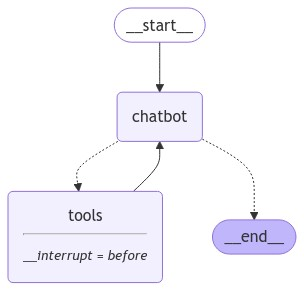

In [ ]:
from IPython.display import Image, display

display(Image(
    graph.get_graph().draw_mermaid_png()
))

We can inspect the curent state as before to confirm the checkpoint reflects our manual updates:

In [ ]:
snapshot = graph.get_state(config)
print(snapshot.values['messages'][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='85325e49-d686-4e2f-a45c-58c62615e949', tool_call_id='toolu_01AyJjvNzsmBKyDWfR9YY8L6'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='fa7cd39c-6e60-42a2-92c0-7dff00dbec6a'), AIMessage(content="I'm an AI expert!", additional_kwargs={}, response_metadata={}, id='a4603647-1a03-4209-b8cf-78236a286a76')]
()


We have continued to add AI messages to the state. Since we act as the `chatbot` and respond with an AIMessage that does not contain `tool_calls`, the graph knows that it has entered a fnished state (`next` is empty).

## What if we want to overwrite existing messages?

The `add_messages` function we used to annotate our graph's `State` controls how updates are made to the `messages` key. This function looks at any message IDs in the new `messages` list. If the ID matches a message in the existing state, `add_messages` overwrites the existing message with the new content.

In [ ]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {
    'configurable': {'thread_id': '2'} # start a new thread
}

events = graph.stream(
    {'messages': [('user', user_input)]},
    config,
    stream_mode='values',
)

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to research LangGraph for you. To get the most up-to-date and comprehensive information, I'll use the Tavily search engine to look this up. Let me do that for you now.", 'type': 'text'}, {'id': 'toolu_019WQXXXx12LmV9maQs8mCNu', 'input': {'query': 'LangGraph framework for language models'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_019WQXXXx12LmV9maQs8mCNu)
 Call ID: toolu_019WQXXXx12LmV9maQs8mCNu
  Args:
    query: LangGraph framework for language models


Next, we update the tool invocation for our agent. We may want to search for human-in-the-loop workflows:

In [ ]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values['messages'][-1]
print("Original")
print('Message ID', existing_message.id)
print(existing_message.tool_calls[0])

new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call['args']['query'] = 'LangGraph human-in-the-loop workflow'
new_messages = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # IMPORTANT:
    # The ID is how LangGraph knows to REPLACE the message in the state
    # rather than APPEND this message
    id=existing_message.id,
)

print("Updated")
print(new_messages.tool_calls[0])
print('Message ID', new_messages.id)
graph.update_state(
    config,
    {'messages': [new_messages]}
)

print('\n\nTool calls')
graph.get_state(config).values['messages'][-1].tool_calls

Original
Message ID run-6d994a9c-953b-4ec2-823a-a86e8aa5890f-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph framework for language models'}, 'id': 'toolu_019WQXXXx12LmV9maQs8mCNu', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'toolu_019WQXXXx12LmV9maQs8mCNu', 'type': 'tool_call'}
Message ID run-6d994a9c-953b-4ec2-823a-a86e8aa5890f-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'toolu_019WQXXXx12LmV9maQs8mCNu',
  'type': 'tool_call'}]

We have modified the AI's tool invocation to search for "LangGraph human-in-the-loop workflow" instead of the simple "LangGraph".

Now we can resume the graph by streaming with an input of `None` and the existing config.

In [ ]:
events = graph.stream(
    None,
    config,
    stream_mode='values',
)
for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to research LangGraph for you. To get the most up-to-date and comprehensive information, I'll use the Tavily search engine to look this up. Let me do that for you now.", 'type': 'text'}, {'id': 'toolu_019WQXXXx12LmV9maQs8mCNu', 'input': {'query': 'LangGraph framework for language models'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_019WQXXXx12LmV9maQs8mCNu)
 Call ID: toolu_019WQXXXx12LmV9maQs8mCNu
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an"}, {"url": "https://m

Notice how the graph queries the search engine using our updated query term. We are able to manually override the LLM's search!

All of this is reflected in the graph's checkpointed memory, meaning if we continue the conversation, it will recall all the *modified* state.

In [ ]:
events = graph.stream(
    {'messages': (
        'user',
        'Remember what I am learning about?',
    )},
    config,
    stream_mode='values',
)

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

Remember what I am learning about?
================================== Ai Message ==================================

Of course! You mentioned that you are learning LangGraph. I apologize for not explicitly restating that in my previous response. To refresh:

You told me: "I'm learning LangGraph."

LangGraph is the topic you're currently studying and interested in. My previous explanation was aimed at providing you with information about LangGraph to support your learning process. Is there a specific aspect of LangGraph you'd like to focus on or any particular questions you have as you're learning about it?


# Customizing State

We have relied on a simple state with a list of messages so far. In this section, we will have a more complicated state to let our chatbot have the choice of relying on a human interruption.

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [ ]:
# New State class
class State(TypedDict):
    messages: Annotated[list, add_messages]
    # add new flag
    ask_human: bool

Next, we define a schema to show the model to let it decide to request assistance.

In [ ]:
from pydantic import BaseModel

class RequestAssistance(BaseModel):
    """
    Escalate the conversation to an expert. Use this if we are unable to assist directly or
    if the user requires support beyond our permissions.

    To use this function, relay the user's `request` so the expert can provide the right guidance.
    """
    request: str

Next, define the chatbot node. The primary modifidiaction is to flip the `ask_human` flag if we see that the chatbot has invoked the `RequestAssistance` flag.

In [ ]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state['messages'])
    ask_human = False

    if (
        response.tool_calls
        and response.tool_calls[0]['name'] == RequestAssistance.__name__
    ):
        ask_human = True

    return {
        'messages': [response],
        'ask_human': ask_human,
    }

Next, create the graph builder and add the chatbot and tools nodes to the graph

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node('chatbot', chatbot)
graph_builder.add_node('tools', ToolNode(tools=tools))

Next, create the "human" `node`, which is a placeholder in our graph that will trigger an interrupt. If the human does not manually update the state during the `interrupt`, it inserts a tool message so the LLM knows the user was requested but didn't respond. This node also unsets the `ask_human` flag so the graph knows not to revisit the node unless further requests are made.

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]['id'],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state['messages'][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response('No response from human.', state['messages'][-1])
        )

    return {
        # Append the new messages
        'messages': new_messages,
        # Unset the flag
        'ask_human': False,
    }


graph_builder.add_node('human', human_node)

Next, define the conditional logic. The `select_next_node` will route to the `human` node if the flag is set. Otherwise, it lets the prebuilt `tools_condition` function choose the next node.

In [ ]:
def select_next_node(state: State):
    if state['ask_human']:
        return 'human'
    # otherwise,
    return tools_condition(state)


graph_builder.add_conditional_edges(
    'chatbot',
    select_next_node,
    {'human': 'human', 'tools': 'tools', END: END},
)

Finally, we add the simple directed edges and compile the graph.

In [ ]:
graph_builder.add_edge('tools', 'chatbot')
graph_builder.add_edge('human', 'chatbot')
graph_builder.add_edge(START, 'chatbot')

memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here
    interrupt_before=['human'],
)

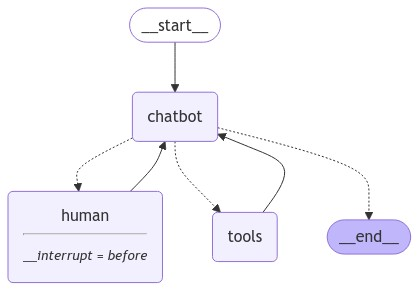

In [ ]:
from IPython.display import Image, display

display(Image(
    graph.get_graph().draw_mermaid_png()
))

The chatbot can either request help from a human (chatbot -> select -> human), invoke the search engine tool (chatbot -> select -> action), or directly responsd (chatbot -> select -> end). Once an action or request has been made, the graph will transition back to the `chatbot` node to continue operatons.

To see this graph in action. We will request for expert assistance to illustrate our graph.

In [ ]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {'configurable': {'thread_id': '1'}}

events = graph.stream(
    {'messages': [('user', user_input)]},
    config,
    stream_mode='values',
)

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to request assistance from an expert regarding guidance for building an AI agent. I'll use the RequestAssistance function to escalate your request to an expert who can provide more specific and detailed information. Let me do that for you right away.", 'type': 'text'}, {'id': 'toolu_01TUZPVfjowi9FuPua6YKAiJ', 'input': {'request': 'The user needs expert guidance for building an AI agent. They are seeking assistance and specialized knowledge in this area.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}]
Tool Calls:
  RequestAssistance (toolu_01TUZPVfjowi9FuPua6YKAiJ)
 Call ID: toolu_01TUZPVfjowi9FuPua6YKAiJ
  Args:
    request: The user needs expert guidance for building an AI agent. They are seek

The LLM has invoked the `RequestAssistance` tool we provided it, and the interrupt has been set. We can inspect the graph state to confirm:

In [ ]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

The graph state is indeed **interrupted** before the `'human'` node. We can act as the "expert" in this scenario and manually update the state by adding a new ToolMessage with our input.

Next, we respond to the chatbot's request by:
1. Creating a `ToolMessage` with our response. This will be passed back to the `chatbot`.
2. Calling `update_state` to manually update the graph state.

In [ ]:
ai_message = snapshot.values['messages'][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

tool_message = create_response(human_response, ai_message)
graph.update_state(
    config,
    {'messages': [tool_message]}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa1022-0d75-6926-8002-3eb8e1dadde5'}}

In [ ]:
graph.get_state(config).values['messages']

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='51ea1237-f818-44bc-851a-85a9ba2232e5'),
 AIMessage(content=[{'text': "Certainly! I'd be happy to request assistance from an expert regarding guidance for building an AI agent. I'll use the RequestAssistance function to escalate your request to an expert who can provide more specific and detailed information. Let me do that for you right away.", 'type': 'text'}, {'id': 'toolu_01TUZPVfjowi9FuPua6YKAiJ', 'input': {'request': 'The user needs expert guidance for building an AI agent. They are seeking assistance and specialized knowledge in this area.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01FRsWZFAqqn8nrqFLxB5Dgy', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 517, 'output_tokens': 131}}, id='r

Next, resume the graph by invoking it with `None` as the inputs.

In [ ]:
events = graph.stream(
    None,
    config,
    stream_mode='values',
)

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Thank you for your patience. I've escalated your request to our expert team, and they have provided some initial guidance. Here's what they suggest:

The experts recommend that you look into LangGraph for building your AI agent. They mention that LangGraph is a more reliable and extensible option compared to simple autonomous agents.

LangGraph is likely a framework or tool designed specifically for creating complex AI age

Now the chatbot has incorporated the updated state in its final response. Since everything was checkpointed, the "expert" human in the loop cloud perform the update at any time without impacting the graph's execution.

# Time Travel

In this section, we will "rewind" our graph by fetching a checkpoint using the graph's `get_state_history` method. We can then resume execution at this previous point in time.

In [ ]:
from typing import Annotated, Literal

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage

from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool


class RequestAssistance(BaseModel):
    """
    Escalate the conversation to an expert. Use this if we are unable to assist directly or
    if the user requires support beyond our permissions.

    To use this function, relay the user's `request` so the expert can provide the right guidance.
    """
    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

In [ ]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state['messages'])
    ask_human = False

    if (
        response.tool_calls
        and response.tool_calls[0]['name'] == RequestAssistance.__name__
    ):
        ask_human = True

    return {
        'messages': [response],
        'ask_human': ask_human,
    }

graph_builder = StateGraph(State)

graph_builder.add_node('chatbot', chatbot)
graph_builder.add_node('tools', ToolNode(tools=tools))

In [ ]:
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]['id'],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state['messages'][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response('No response from human.', state['messages'][-1])
        )

    return {
        # append new messages
        'messages': new_messages,
        # unset the flag
        'ask_human': False,
    }


graph_builder.add_node('human', human_node)

In [ ]:
def select_next_node(state: State):
    if state['ask_human']:
        return 'human'

    # otherwise
    return tools_condition(state)


graph_builder.add_conditional_edges(
    'chatbot',
    select_next_node,
    {'human': 'human', 'tools': 'tools', END: END},
)

graph_builder.add_edge('tools', 'chatbot')
graph_builder.add_edge('human', 'chatbot')
graph_builder.add_edge(START, 'chatbot')

memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=['human'],
)

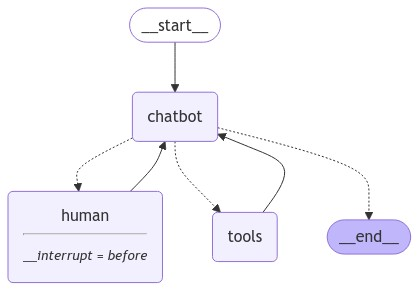

In [ ]:
from IPython.display import Image, display

display(Image(
    graph.get_graph().draw_mermaid_png()
))

Let's have our graph take a couple steps. Every step will be checkpointed in its state history:

In [ ]:
config = {'configurable': {'thread_id': '1'}}
events = graph.stream(
    {
        'messages': [
            ('user', "I'm learning LangGraph. Could you do some research on it for me?"),
        ]
    },
    config,
    stream_mode='values',
)

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to research LangGraph for you. To get the most up-to-date and comprehensive information, I'll use the Tavily search engine to look this up. Let me do that for you now.", 'type': 'text'}, {'id': 'toolu_01NwgkDb768BV3ok6wnFwHZb', 'input': {'query': 'LangGraph framework for language models'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01NwgkDb768BV3ok6wnFwHZb)
 Call ID: toolu_01NwgkDb768BV3ok6wnFwHZb
  Args:
    query: LangGraph framework for language models
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph provides a

In [ ]:
events = graph.stream(
    {
        'messages': [
            ('user', "Yes that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode='values',
)

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

Yes that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

[{'text': "That's an excellent idea! Building an autonomous agent with LangGraph is a great way to apply your learning and explore the capabilities of this framework. Let me provide some insights and suggestions to help you get started with this project.", 'type': 'text'}, {'id': 'toolu_01Wfn9BfnEJ7gJa9uh6ZH8uT', 'input': {'query': 'building autonomous agents with LangGraph and LangChain'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01Wfn9BfnEJ7gJa9uh6ZH8uT)
 Call ID: toolu_01Wfn9BfnEJ7gJa9uh6ZH8uT
  Args:
    query: building autonomous agents with LangGraph and LangChain
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "ht

Now that we have had the agent take a couple of steps, we can `replay` the full state history to see everything that occurred.

In [ ]:
to_replay = None

for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values['messages']), "Next, ", state.next)
    print('-'*80)

    if len(state.values['messages']) == 6:
        # We are somehow arbitrarily selecting a specific state based on
        # the number of chat meesages in the state
        to_replay = state

Num Messages:  8 Next,  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next,  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next,  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next,  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next,  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next,  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next,  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next,  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next,  ('chatbot',)
-----------------------------------------

Checkpoints are saved for every step of the graph. This spans invocations so we can rewind across a full thread's history. We picked out `to_replay` as a state to resume from. This is the state after the `chatbot` node in the second graph invocation:

In [ ]:
to_replay.values

{'messages': [HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", additional_kwargs={}, response_metadata={}, id='51e00848-4136-45eb-9505-e1d640154233'),
  AIMessage(content=[{'text': "Certainly! I'd be happy to research LangGraph for you. To get the most up-to-date and comprehensive information, I'll use the Tavily search engine to look this up. Let me do that for you now.", 'type': 'text'}, {'id': 'toolu_01NwgkDb768BV3ok6wnFwHZb', 'input': {'query': 'LangGraph framework for language models'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01BU4M9QhgXP4edHVgMeA3eD', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 516, 'output_tokens': 115}}, id='run-9c2f92fc-07b4-4eed-acdc-0070e7d16c33-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph framework for language models'}, 'id': 'toolu_01Nwg

Resuming from this point should call the **action** node next.

In [ ]:
to_replay.next

('tools',)

In [ ]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa113a-959b-6ff7-8006-4b1bce9b9bb2'}}

The checkopint's config `to_replay.config` contains a `checkpoint_id` timestamp. Providing this `checkpoint_id` value tells LangGraph's checkpointer to load the state from that moment in time.

In [ ]:
# `checkpoint_id` in the `to_replay.config` corresponds to a state we persisted to our checkpointer
for event in graph.stream(
    None,
    to_replay.config,
    stream_mode='values',
):
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "That's an excellent idea! Building an autonomous agent with LangGraph is a great way to apply your learning and explore the capabilities of this framework. Let me provide some insights and suggestions to help you get started with this project.", 'type': 'text'}, {'id': 'toolu_01Wfn9BfnEJ7gJa9uh6ZH8uT', 'input': {'query': 'building autonomous agents with LangGraph and LangChain'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01Wfn9BfnEJ7gJa9uh6ZH8uT)
 Call ID: toolu_01Wfn9BfnEJ7gJa9uh6ZH8uT
  Args:
    query: building autonomous agents with LangGraph and LangChain
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.langchain.dev/how-to-build-the-ultimate-ai-automation-with-multi-agent-collaboration/", "content": "Introducing LangGraph. LangGraph is a